In [1]:
from matplotlib import pyplot as plt
from earthdaily import earthdatastore
from earthdaily.earthdatastore import cube_utils
from sklearn import metrics
import geopandas as gpd
import numpy as np
import os
import tqdm
import xarray as xr
import utils

In [2]:
os.environ["GDAL_DATA"] = os.environ["CONDA_PREFIX"] + r"\Library\share\gdal"
os.environ["PROJ_LIB"] = os.environ["CONDA_PREFIX"] + r"\Library\share\proj"

## Generate dataset from the earthdaily simulation

The earthdaily simulated dataset is a simulation using various Sensors (Venus, Sentinel-2, Landsat, Modis) in order to have a cloudless version of what will be available when the EarthDaily constellation will be here. 5m spatial resolution on VNIR bands, daily revisit, radiometric scientific grade quality...
As it is cloudless, it is an Analytics Ready Product.

In [3]:
year = 2020
df = utils.get_df(year)
bbox = df.to_crs(4326).total_bounds.tolist()

In [4]:
generate_dataset = False
days_interval = 5  # one information every x days (default=5)

if generate_dataset:
    eds = earthdatastore.Auth()
    items = eds.search(
        "earthdaily-simulated-cloudless-l2a-cog-edagro",
        bbox=bbox,
        datetime=[f"{year}-05-15", f"{year}-10-15"],
        prefer_alternate="download",
        query=dict(instruments={"contains": "vnir"}),
    )
    # get only one item every 5 days  (days_interval)
    items = [items[i] for i in np.arange(0, len(items), days_interval)]
    datacube_sr = earthdatastore.datacube(
        items,
        bbox=bbox,
        assets={
            "image_file_B": "blue",
            "image_file_G": "green",
            "image_file_Y": "yellow",
            "image_file_R": "red",
            "image_file_RE1": "redege1",
            "image_file_RE2": "redege2",
            "image_file_RE3": "redege3",
            "image_file_NIR": "nir",
        },
    )
    # if you want to search and create the cube all in one time
    # datacube_sr = eds.datacube(
    #     "earthdaily-simulated-cloudless-l2a-cog-edagro",
    #     bbox=bbox,
    #     datetime=[f"{year}-05-15", f"{year}-10-15"],
    #     assets={
    #         "image_file_B": "blue",
    #         "image_file_G": "green",
    #         "image_file_Y": "yellow",
    #         "image_file_R": "red",
    #         "image_file_RE1": "redege1",
    #         "image_file_RE2": "redege2",
    #         "image_file_RE3": "redege3",
    #         "image_file_NIR": "nir",
    #     },
    #     search_kwargs=dict(query=dict(instruments={"contains":"vnir"})),
    #     prefer_alternate="download" # to have presigned urls
    # )
    # datacube_sr = datacube_sr.isel(time=np.arange(0, datacube_sr.time.size, days_interval))

    for data_var in datacube_sr:
        data_var_nc = f"data/eds/{year}/{data_var}.nc"
        if os.path.exists(data_var_nc):
            continue
        os.makedirs(f"data/eds/{year}", exist_ok=True)
        ds_stats = cube_utils.zonal_stats_numpy(datacube_sr, df)
        ds_stats.to_netcdf(data_var_nc)

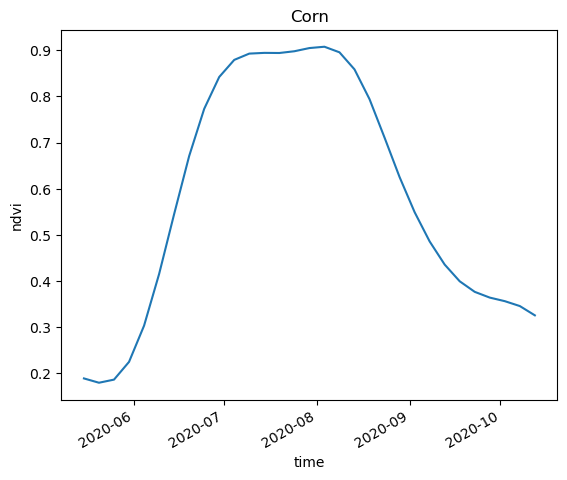

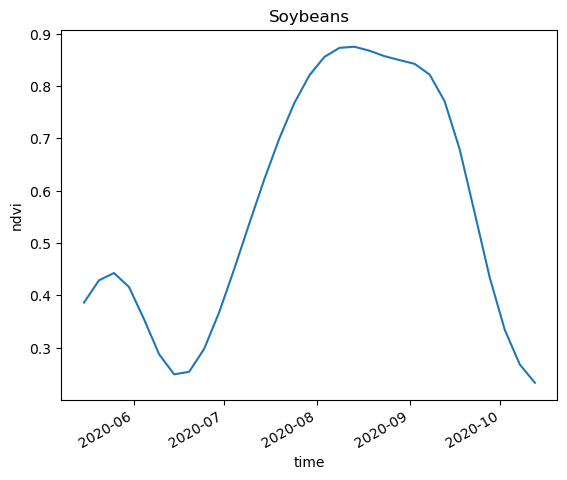

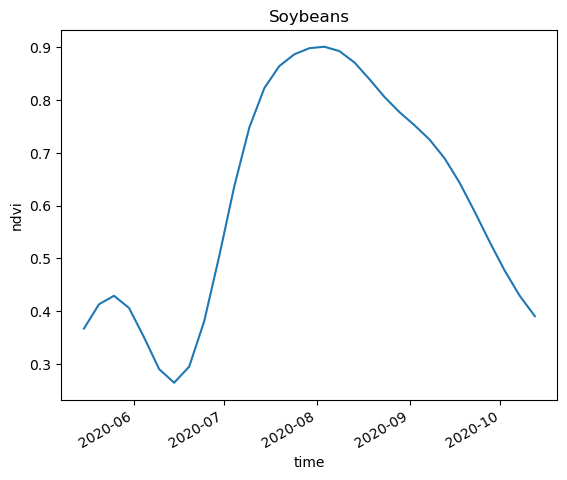

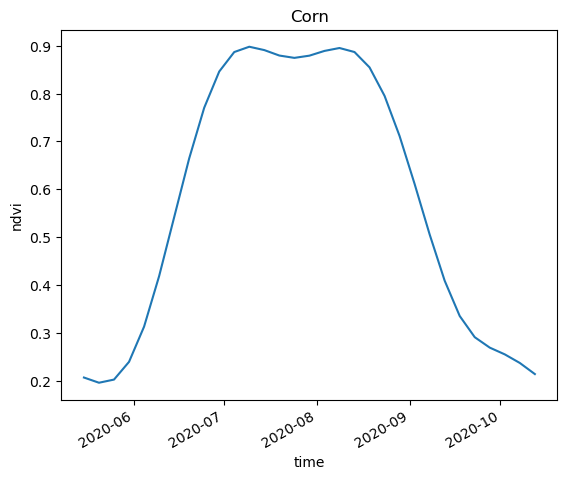

In [5]:
ds = utils.X_year(year, to_numpy=False, return_feature_index=False)
for feature_idx in [500, 1000, 1500, 2000]:
    ds["ndvi"].isel(feature=feature_idx, stats=0).plot()
    plt.title(utils.y_labels[df.iloc[feature_idx][f"R{str(year)[2:]}"]])
    plt.show()

# Generate trainig/testing data


In [6]:
# We suppose we have data only up to 15 july.
end_datetime = "07-15"  # july 15
# you can go up to 10-15 (october 15)
X_18, y_18 = utils.X_y(2018, end_datetime=end_datetime)
X_19, y_19 = utils.X_y(2019, end_datetime=end_datetime)
X_20, y_20 = utils.X_y(2020, end_datetime=end_datetime)

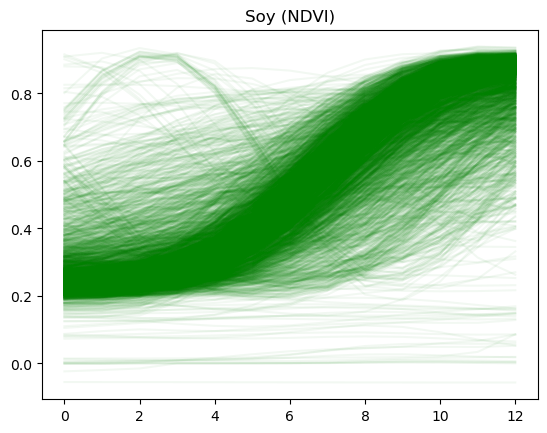

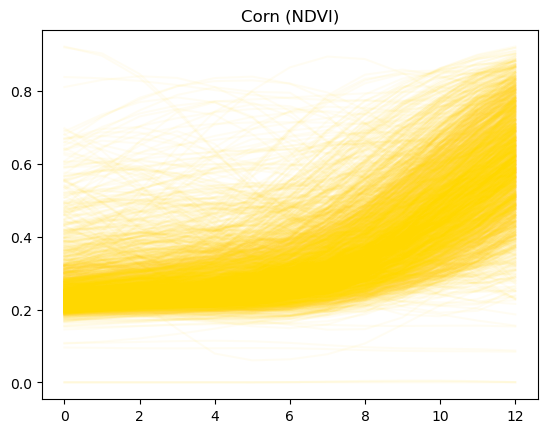

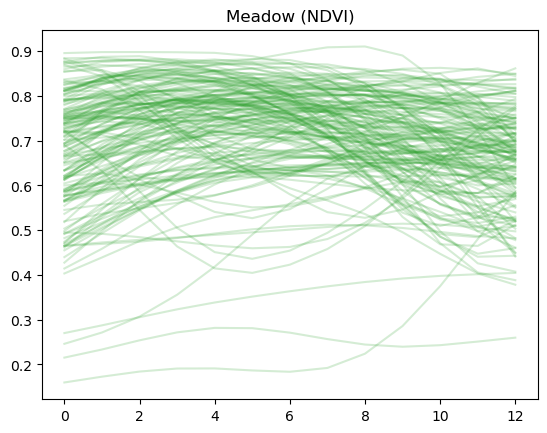

In [7]:
plt.title("Soy (NDVI)")
soy = np.in1d(y_19, 1)
plt.plot(
    X_19[soy, :][:, np.arange(8, X_19.shape[1], 9)].T, alpha=0.05, c="green"
)
plt.show()
plt.title("Corn (NDVI)")
corn = np.in1d(y_19, 5)
plt.plot(
    X_19[corn, :][:, np.arange(8, X_19.shape[1], 9)].T, alpha=0.05, c="gold"
)
plt.show()
plt.title("Meadow (NDVI)")
meadow = np.in1d(y_19, 176)
plt.plot(
    X_19[meadow, :][:, np.arange(8, X_19.shape[1], 9)].T, alpha=0.2, c="C2"
)
plt.show()

# Machine Learning
We use Random Forest and XGBoost to train on one or two years, and to predict on year 2019.

In [8]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [9]:
model = RandomForestClassifier()  # default parameters

In [10]:
# class are not following number (they are like 1,5,205)... Torch and xgb needs following numbers (0,1,2,3)
y_18 = utils.y_to_range(y_18)
y_19 = utils.y_to_range(y_19)
y_20 = utils.y_to_range(y_20)

In [11]:
# # for xgboost, only support class range(0 to n)
model = xgb.XGBClassifier()  #

cm_plot_kwargs = dict(
    display_labels=list(utils.y_labels.values()),
    cmap="Blues",
    xticks_rotation="vertical",
    colorbar=False,
)

Score when training with 2018 : 0.722905982905983


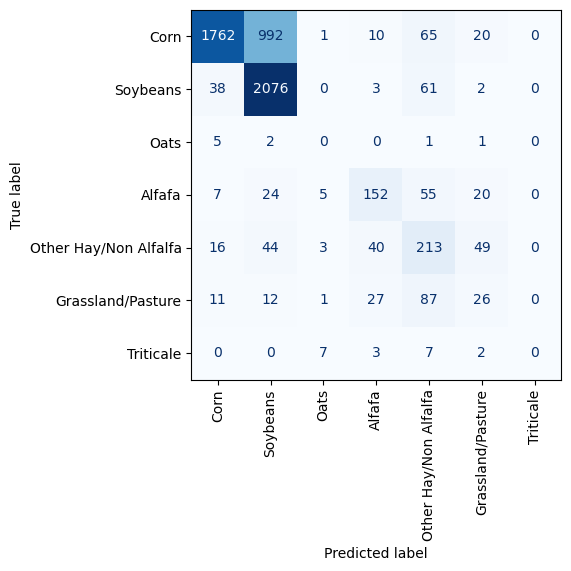

In [12]:
model.fit(X_18, y_18)
y_pred = model.predict(X_19)
score = metrics.accuracy_score(y_19, y_pred)
print(f"Score when training with 2018 : {score}")
y_pred_19 = model.predict(X_19)
metrics.ConfusionMatrixDisplay.from_predictions(
    y_19, y_pred, **cm_plot_kwargs
)

Score when training with 2020 : 0.8145299145299145


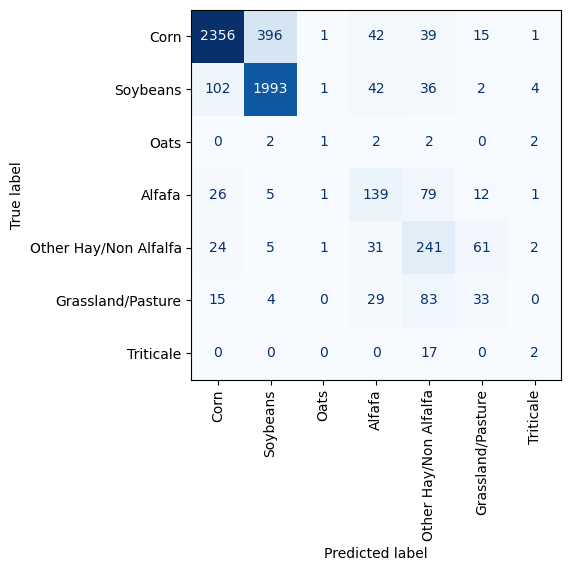

In [13]:
model.fit(X_20, y_20)
y_pred = model.predict(X_19)
score = metrics.accuracy_score(y_19, y_pred)
print(f"Score when training with 2020 : {score}")
metrics.ConfusionMatrixDisplay.from_predictions(
    y_19, y_pred, **cm_plot_kwargs
)

Score when training with 2018 and 2020 : 0.7976068376068376


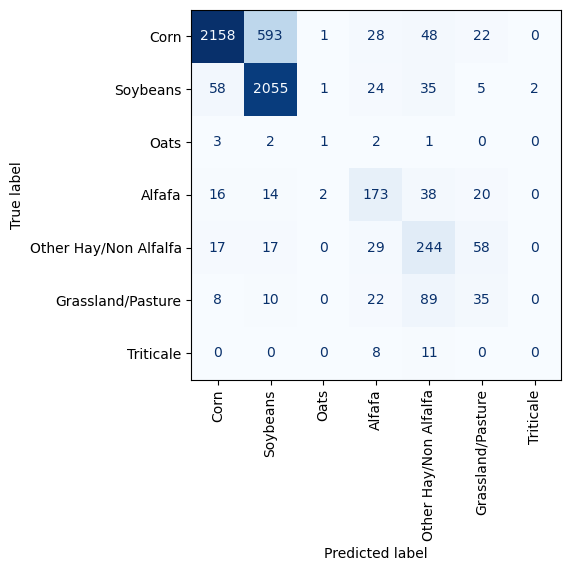

In [14]:
model.fit(np.vstack((X_18, X_20)), np.hstack((y_18, y_20)))
y_pred = model.predict(X_19)
score = metrics.accuracy_score(y_19, y_pred)
print(f"Score when training with 2018 and 2020 : {score}")
metrics.ConfusionMatrixDisplay.from_predictions(
    y_19, y_pred, **cm_plot_kwargs
)

# Deep Learning (RNN) : ELECTS model

epoch 100: trainloss -0.58, testloss 2.56, accuracy 0.77, earliness 0.33. classification loss 8.62, earliness reward 3.


Score when training with 2018 and 2020 : 0.7716239316239316


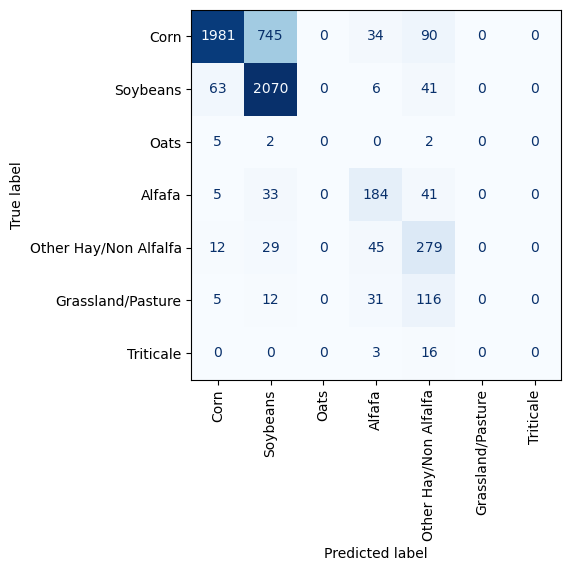

In [15]:
import elects

n_bands = 9  # VNIR + NDVI

train_ds = utils.torch_dataset(X_18, y_18, n_bands=n_bands)
test_ds = utils.torch_dataset(X_19, y_19, n_bands=n_bands)

model = elects.train(
    train_ds,
    test_ds,
    n_classes=len(utils.y_labels),
    epochs=100,
    n_bands=n_bands,
)

y_pred = model.predict(utils.x_to_torch(X_19, n_bands))[2].detach().numpy()

score = metrics.accuracy_score(y_19, y_pred)
print(f"Score when training with 2018 and 2020 : {score}")

metrics.ConfusionMatrixDisplay.from_predictions(
    y_19, y_pred, **cm_plot_kwargs
)

# Train with two years

resuming from snapshots/model.pth epoch 88


epoch 176: trainloss 0.05, testloss 1.21, accuracy 0.81, earliness 0.45. classification loss 6.55, earliness reward 4.1


stopping training. testloss 1.21 did not improve in 30 epochs.
Score when training with 2018 and 2020 : 0.8094017094017094


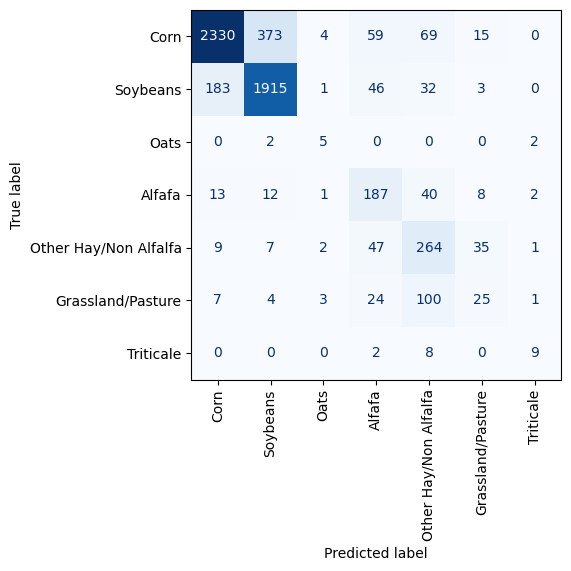

In [16]:

# if you want to train a new big dataset with the 2 years
resume = False
train_ds = utils.torch_dataset(
    np.vstack((X_18, X_20)), np.hstack((y_18, y_20)), n_bands=n_bands
)

# or just add 2020 and resume previous training
resume = True
train_ds = utils.torch_dataset(X_20, y_20, n_bands=n_bands)


model = elects.train(
    train_ds,
    test_ds,
    n_classes=len(utils.y_labels),
    epochs=200,  # add 100 epochs
    n_bands=n_bands,
    resume=resume,  # in order to start using previous training
)

y_pred = model.predict(utils.x_to_torch(X_19, n_bands))[2].detach().numpy()

score = metrics.accuracy_score(y_19, y_pred)
print(f"Score when training with 2018 and 2020 : {score}")

metrics.ConfusionMatrixDisplay.from_predictions(
    y_19, y_pred, **cm_plot_kwargs
)